In [1]:
import sys
sys.path.append('..') #to add top-level to path

from modules.project_helper import TweetData, FuturesCloseData
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Tweet Returns Features

This notebook creates features derived from Trump's tweets, where we try to model the 'return' of every tweet. We look at all tweets in a day, from market close to market close, and see the one day return for every instrument. We attribute every word in the tweeted these returns, and calculate the cumulative mean returns, or the **score**, for every word for every day for every asset. 

From here we have three features: 

- **daily_tweet_score**: The average of the scores for every word tweeted in a day.
- **max_tweet_score**: The score of the tweet with the highest score in a day.
- **min_tweet_score**: The score of the tweet with the highest score in a day.

Obtaining tweet data and futures closing data to calculate returns.

In [2]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
tweet_data = TweetData()
fc = FuturesCloseData()

Creating a pandas dataframe with daily log returns for all assets, and a text column which contains all tweets in that day (market close to market close). We look at log-returns since they can be easily aggregated by adding them.

In [3]:
daily_df = pd.read_csv('../data/intermediate_data/combined_daily_tweets.csv', header=None)
daily_df.columns =['date','text']
daily_df.date = pd.to_datetime(daily_df.date)
daily_df = daily_df.set_index('date')
# Start of training period
daily_df = daily_df[daily_df.index >= pd.to_datetime('2016-10-03')]
# Dropping NAs, ie days with no returns, like weekends and holidays
daily_df = daily_df.join(fc.log_returns()).dropna()

In [4]:
daily_df.head(3)

,text,ES,NQ,CD,EC,JY,MP,TY,US,C,S,W,CL,GC
date,,,,,,,,,,,,,,
2016-10-03,join me in henderson nevada on wednesday at am...,-0.003920,-0.001624,-0.006520,-0.001899,-0.011445,0.000233,-0.003515,-0.010427,0.005206,-0.007537,-0.000405,-0.002218,-0.031237
2016-10-04,join me in reno nevada on wednesday at pm at t...,0.003920,0.003147,0.002264,0.001239,-0.007687,0.005585,-0.002188,-0.004647,-0.001559,-0.004984,0.014093,0.020876,-0.000812
2016-10-05,the constant interruptions last night by tim k...,0.001495,-0.000295,-0.004598,-0.006168,-0.004767,-0.001626,-0.002071,-0.004262,-0.015195,0.001086,-0.014093,0.010994,-0.011587


- Creating dataframe with indices all the words in Trump's vocabulary, and rows the 1 day returns for each word for each day
- I clipped the return at 0.5% to avoid days with very large returns dominating the singal

In [ ]:
word_ret_dict = {}
for inst in instrument_list:

    word_ret_df = pd.DataFrame(index = list(set(tweet_data.clean_tweets.tweets.str.cat(sep=' ').split())), 
                               columns = range(len(daily_df.index)))
    word_ret_df = word_ret_df.fillna(0)
    for i in tqdm(range(word_ret_df.shape[1])):
        num = daily_df[inst][i].clip(-0.05,0.05)
        word_ret_df[i].loc[daily_df.text[i].split()] = num
    word_ret_dict[inst] = word_ret_df

 45%|████████████████████████████████████████▌                                                 | 347/770 [00:32<00:59,  7.12it/s]

Creating a dataframe with mean cumulative returns from the dataframes created above. 

In [ ]:
word_ret_cum_mean_dict = {}
for inst in tqdm(instrument_list):
    word_ret_cum_mean_dict[inst] = word_ret_dict[inst].cumsum(axis=1)/np.arange(1,word_ret_dict[inst].shape[1]+1)

Mean cumulative returns for daily tweets in the last day of the dataset, for S&P500 futures, sorted. 

In [7]:
word_ret_cum_mean_dict['ES'][769].sort_values().head(10)

getting    -0.000252
happy      -0.000238
paying     -0.000202
against    -0.000177
support    -0.000175
farmers    -0.000172
pelosi     -0.000171
spending   -0.000166
just       -0.000165
billion    -0.000163
Name: 769, dtype: float64

- Creating feature **daily_tweet_score**: Average cumulative word returns as of yesterday, for every word in all tweets that day. This is a return for all the words Trump tweeted in a day. 
- Considering only days where he tweeted more than 10 words to avoid noise of single word returns.

In [8]:
for inst in tqdm(instrument_list):
    vc = np.zeros(daily_df.shape[0])
    for i in range(1, daily_df.shape[0]):
        sp = daily_df.text[i].split()
        if len(sp) <=10:
            vc[i] = 0
        else:
            vc[i]= sum(word_ret_cum_mean_dict[inst][i-1].loc[sp]/len(sp))
    daily_df['{}_daily_tweet_score'.format(inst)] = vc

100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


In [9]:
daily_df.columns

Index(['text', 'ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W',
       'CL', 'GC', 'ES_daily_tweet_score', 'NQ_daily_tweet_score',
       'CD_daily_tweet_score', 'EC_daily_tweet_score', 'JY_daily_tweet_score',
       'MP_daily_tweet_score', 'TY_daily_tweet_score', 'US_daily_tweet_score',
       'C_daily_tweet_score', 'S_daily_tweet_score', 'W_daily_tweet_score',
       'CL_daily_tweet_score', 'GC_daily_tweet_score'],
      dtype='object')

Now, we are going to get word returns for every tweet. Getting single tweet data, with timestamp.

In [74]:
daily_tweets = tweet_data.clean_tweets[pd.to_datetime(tweet_data.clean_tweets.after4_date)
                                       <= pd.to_datetime(daily_df.index[-1])]
daily_tweets.after4_date = pd.to_datetime(daily_tweets.after4_date)

In [75]:
daily_tweets.head()

,tweets,timestamp,after4_date
timestamp,,,
2019-11-07 14:51:38-06:00,what did hunter biden do for the money a very ...,2019-11-07 14:51:38-06:00,2019-11-07
2019-11-07 14:00:34-06:00,based on the information released last night a...,2019-11-07 14:00:34-06:00,2019-11-07
2019-11-07 13:47:57-06:00,read the transcript,2019-11-07 13:47:57-06:00,2019-11-07
2019-11-07 13:46:30-06:00,the degenerate washington post made up the sto...,2019-11-07 13:46:30-06:00,2019-11-07
2019-11-07 12:28:41-06:00,bill barr did not decline my request to talk a...,2019-11-07 12:28:41-06:00,2019-11-07


Creating a dictionary of dates as keys and indices as values, to match the format of the return matrices above. Adding an indicator row to daily_tweets dataframe with the day, and then removing all days with no returns (like on weekends and holidays)

In [76]:
date_dict = {date : i for i,date in enumerate(daily_df.index)}
daily_tweets['ind']=[date_dict[date] if date in date_dict.keys() else 0 for date in daily_tweets.after4_date]
daily_tweets = daily_tweets[daily_tweets.ind!=0]

Calculating returns for every tweet:

In [77]:
for inst in tqdm(instrument_list):
    tc = np.zeros(daily_tweets.shape[0])
    i = 0
    for tweet, ind  in zip(daily_tweets.tweets,daily_tweets.ind):
        tw = tweet.split()
        if ind > 0:
            if len(tw) <=10:
                tc[i] = 0
            else:
                tc[i]= sum(word_ret_cum_mean_dict[inst][ind-1].loc[tw])
        i = i+1
    daily_tweets['{}_single_ret'.format(inst)] = tc
    

100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


In [56]:
daily_tweets.columns

Index(['tweets', 'timestamp', 'after4_date', 'ind', 'ES_single_ret',
       'NQ_single_ret', 'CD_single_ret', 'EC_single_ret', 'JY_single_ret',
       'MP_single_ret', 'TY_single_ret', 'US_single_ret', 'C_single_ret',
       'S_single_ret', 'W_single_ret', 'CL_single_ret', 'GC_single_ret'],
      dtype='object')

- The signal takes some time to train as you need to build vocabulary returns. We can't train the model on words much before the election since there wasn't a causal relation between Trump's tweets and the market before that time. Looking at the signal, it seems to stabilize by February 2017.
- We also need to remove tweets with exactly zero return, which are most likely tweets with less than 10 words.

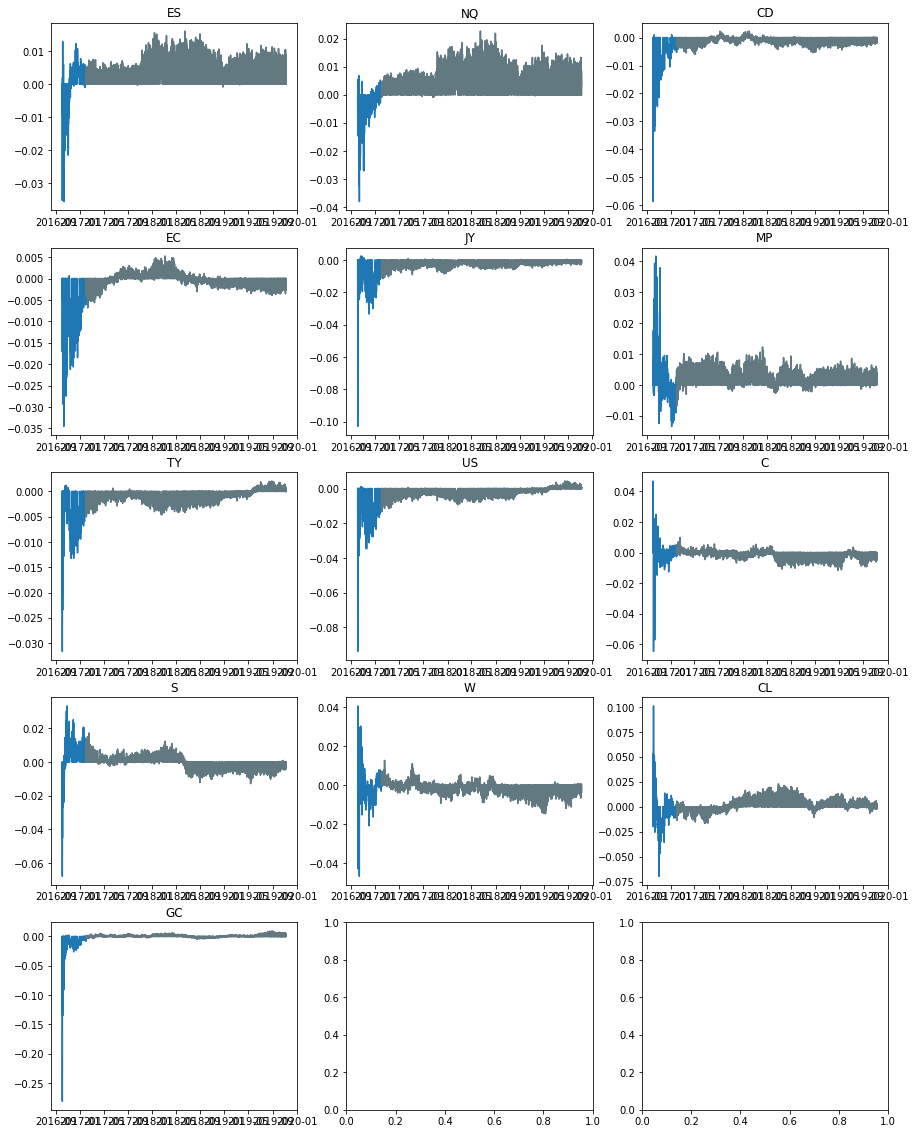

In [78]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(daily_tweets['{}_single_ret'.format(inst)])
    ax[i].plot(daily_tweets[daily_tweets.after4_date >= 
                            pd.to_datetime('2017-02-01')]['{}_single_ret'.format(inst)], alpha =0.3)
    ax[i].set_title(inst)

In [79]:
final_daily_tweets = daily_tweets[daily_tweets.after4_date >= pd.to_datetime('2017-02-01')]

Calculating the 3 features:

- **daily_tweet_score**: The average of the scores for every word tweeted in a day.
- **max_tweet_score**: The score of the tweet with the highest score in a day.
- **min_tweet_score**: The score of the tweet with the highest score in a day.

In [90]:
tweet_returns_features = pd.DataFrame()
for inst in instrument_list:
    final_nozero = final_daily_tweets[final_daily_tweets[inst+'_single_ret']!=0]
    tweet_returns_features[inst + '_min_tweet'] = final_nozero.groupby('after4_date').min()[inst+'_single_ret']
    tweet_returns_features[inst + '_max_tweet'] = final_nozero.groupby('after4_date').max()[inst+'_single_ret']
    tweet_returns_features[inst + '_daily_tweet'] = daily_df[inst + '_daily_tweet_score']

In [86]:
tweet_returns_features.head()

,ES_min_tweet,ES_max_tweet,ES_daily_tweet,NQ_min_tweet,NQ_max_tweet,NQ_daily_tweet,CD_min_tweet,CD_max_tweet,CD_daily_tweet,EC_min_tweet,...,S_daily_tweet,W_min_tweet,W_max_tweet,W_daily_tweet,CL_min_tweet,CL_max_tweet,CL_daily_tweet,GC_min_tweet,GC_max_tweet,GC_daily_tweet
after4_date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.001327,0.003084,0.000107,0.000571,0.002905,0.000073,-0.002969,-0.002929,-0.000100,-0.003917,...,0.000398,0.003273,0.006890,0.000194,-0.013598,-0.001480,-0.000214,-0.002968,-0.001088,-0.000081
2017-02-02,0.000208,0.004080,0.000087,-0.000857,0.004524,0.000059,-0.002516,-0.000271,-0.000067,-0.004292,...,0.000351,0.000942,0.005961,0.000150,-0.004577,0.004341,-0.000049,-0.003318,0.001901,-0.000045
2017-02-03,0.001417,0.005195,0.000137,0.001009,0.002715,0.000091,-0.002650,-0.001324,-0.000089,-0.003618,...,0.000260,-0.000125,0.003374,0.000053,-0.006212,0.003012,-0.000063,-0.002248,-0.000739,-0.000065
2017-02-06,0.001328,0.003935,0.000134,-0.000043,0.003033,0.000078,-0.002640,-0.001264,-0.000091,-0.003573,...,0.000300,-0.000476,0.001749,0.000019,-0.004039,0.004057,-0.000061,-0.002235,0.000442,-0.000043
2017-02-07,0.001821,0.004572,0.000142,0.001859,0.004924,0.000130,-0.004049,-0.001284,-0.000126,-0.004124,...,0.000427,0.001428,0.004803,0.000128,-0.008617,-0.002396,-0.000212,-0.000658,0.001226,-0.000011


In [ ]:
tweet_returns_features.index.name = 'date'
tweet_returns_features.to_csv('../data/features/tweet_returns.csv')

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(tweet_returns_features['{}_daily_tweet'.format(inst)])
    ax[i].set_title(inst)

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(tweet_returns_features['{}_min_tweet'.format(inst)])
    ax[i].set_title(inst)

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(tweet_returns_features['{}_max_tweet'.format(inst)])
    ax[i].set_title(inst)